# Reinforcement learning for sigma-lognormal modeling of ECG beats

#### Imports

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.vec_normalize import VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO

from rl import get_bounds, lognpdf, SigmaECGEnv, get_template_ecg

#### Loading data

In [3]:
# This dataframe is generated in ECG_data_validation.ipynb
segment_df = pd.read_pickle("/Users/christian/Library/CloudStorage/OneDrive-UniversityofSouthCarolina/Data/clean_ecg_for_RL.pck")

#### Getting the sigma-lognormal template for the ECG beats

In [4]:
ecg_beat_template, lower_bound, upper_bound = get_template_ecg()

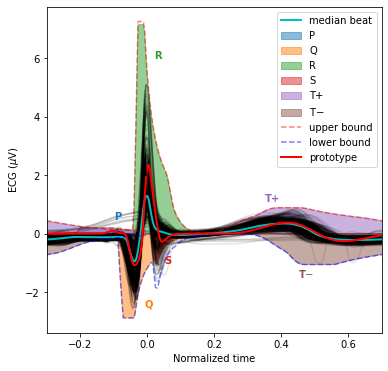

In [7]:
plt.figure(figsize=(6, 6))
t = np.arange(-1, 1, 1/250)
imin = 175
imax = 425

for t_shift in [0, 1]:
    t -= t_shift
    plt.plot(t, np.stack(segment_df.mean_beat).T*1000, alpha=0.1, 
             color="k")
    plt.plot(t, np.median(np.stack(segment_df.mean_beat)*1000, 0), 
             linewidth=2, color="c", 
             label="median beat" if t_shift else None)

    ubs, lbs = np.array([get_bounds(t+t_shift, param_lower, param_upper)
                         for param_lower, param_upper 
                         in zip(lower_bound.params.values(), 
                                upper_bound.params.values())]).transpose([1, 0, 2])
    for label, ub, lb, ln, color in zip(["P", "Q", "R", "S", "T+", r"T$-$"], ubs, lbs, 
                                        ecg_beat_template.params.values(), 
                                        ["C0", "C1", "C2", "C3", "C4", "C5"]):
        plt.fill_between(t, lb*1000, ub*1000, alpha=0.5, color=color, 
                         label=label if t_shift else None)

    ub = np.array(ubs).sum(0)
    lb = np.array(lbs).sum(0) 

    plt.plot(t, ub*1000, color="r", linestyle='dashed', 
             alpha=0.5, label="upper bound" if t_shift else None)
    plt.plot(t, lb*1000, color="b", linestyle='dashed', 
             alpha=0.5, label="lower bound" if t_shift else None)

    template = np.sum(np.array([lognpdf(t, **ln) for ln in ecg_beat_template.params.values()]), axis=0)
    plt.plot(t, template*1000, color="r", linewidth=2, 
             label="prototype" if t_shift else None)
    
plt.text(-0.1, 0.5, "P", color="C0", weight="bold")
plt.text(-0.01,-2.5, "Q", color="C1", weight="bold")
plt.text(0.02, 6, "R", color="C2", weight="bold")
plt.text(0.05, -1, "S", color="C3", weight="bold")
plt.text(0.35, 1.1, "T+", color="C4", weight="bold")
plt.text(0.45, -1.5, r"T$-$", color="C5", weight="bold")
plt.xlim(-0.3, 0.7)

plt.xlabel("Normalized time")
plt.ylabel(r"ECG ($\mu$V)")

plt.legend()

plt.savefig("prototype.png")

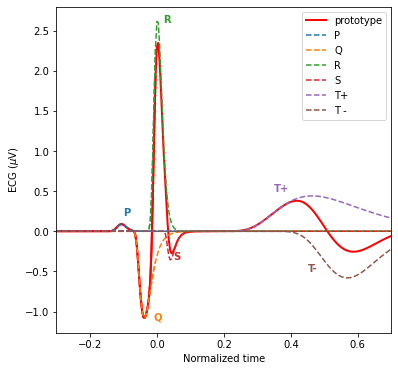

In [20]:
plt.figure(figsize=(6, 6))
t = np.arange(-1, 1, 1/250)
imin = 175
imax = 425

for t_shift in [0, 1]:
    t -= t_shift

    template = np.sum(np.array([lognpdf(t, **ln) for ln in ecg_beat_template.params.values()]), axis=0)
    plt.plot(t, template*1000, color="r", linewidth=2, 
             label="prototype" if t_shift else None)
    

    for label, ln, color in zip(["P", "Q", "R", "S", "T+", "T -"], 
                                        ecg_beat_template.params.values(), 
                                        ["C0", "C1", "C2", "C3", "C4", "C5"]):
        plt.plot(t, lognpdf(t, **ln)*1000, color=color, linestyle="dashed", 
                         label=label if t_shift else None)


plt.text(-0.1, 0.2, "P", color="C0", weight="bold")
plt.text(-0.01,-1.1, "Q", color="C1", weight="bold")
plt.text(0.02, 2.6, "R", color="C2", weight="bold")
plt.text(0.05, -0.35, "S", color="C3", weight="bold")
plt.text(0.35, 0.5, "T+", color="C4", weight="bold")
plt.text(0.45, -0.5, "T-", color="C5", weight="bold")
plt.xlim(-0.3, 0.7)

plt.xlabel("Normalized time")
plt.ylabel(r"ECG ($\mu$V)")

plt.legend()

#plt.savefig("prototype.png")

<AxesSubplot:ylabel='Count'>

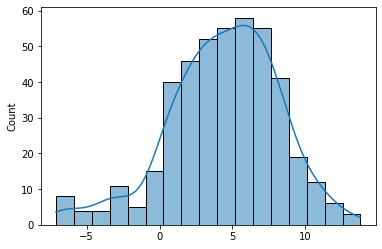

In [5]:
# This histogram is an indicator of inter-subject variability, as opposed
# to the SNR histograms in ECG_data_validation.ipynb which are indicators
# of within subject variability
mean_beats = np.stack(segment_df.mean_beat)
signal = np.trapz(np.median(mean_beats, 0)**2)
noise = np.trapz((mean_beats - np.median(mean_beats, 0))**2, axis=1)
sns.histplot(10*np.log10(signal/noise), kde=True)

<AxesSubplot:>

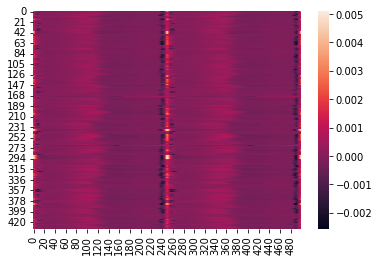

In [6]:
sns.heatmap(mean_beats)

#### Training

In [8]:
log_path = Path('Training', 'Logs')
log_path.mkdir(exist_ok=True, parents=True)

env = SigmaECGEnv(segment_df, lower_bound, upper_bound, ecg_beat_template)

In [9]:
model = PPO("MultiInputPolicy", VecNormalize(DummyVecEnv([lambda: Monitor(env)])), 
            verbose=1, tensorboard_log=log_path)

model.learn(total_timesteps=3000000, tb_log_name="vanilla_normalized_final")
model.save('PPO_vanilla_normalized_final')

Using cpu device


In [17]:
net_arch = { "small": [dict(pi=[64, 64], vf=[64, 64])],
             "medium": [dict(pi=[256, 256], vf=[256, 256])]}
activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}

model = PPO("MultiInputPolicy", VecNormalize(DummyVecEnv([lambda: Monitor(env)])), 
            batch_size=128, n_steps=8, gamma=0.9999, learning_rate=0.0001505987577625739, 
            ent_coef=6.72196705623258e-07, clip_range=0.3, n_epochs=1, gae_lambda=0.9, 
            max_grad_norm=2, vf_coef=0.9794367304554075, sde_sample_freq=16, 
            policy_kwargs=dict(net_arch=net_arch["medium"], activation_fn=activation_fn["tanh"], ortho_init=False),
            verbose=1, tensorboard_log=log_path)

model.learn(total_timesteps=3000000, tb_log_name="tuned6", log_interval=100)
model.save('PPO_tuned6')

Using cpu device
Logging to Training/Logs/tuned6_3
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 138      |
|    ep_rew_mean          | -1.09    |
| time/                   |          |
|    fps                  | 268      |
|    iterations           | 100      |
|    time_elapsed         | 2        |
|    total_timesteps      | 800      |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.3      |
|    entropy_loss         | -34.1    |
|    explained_variance   | -0.925   |
|    learning_rate        | 0.000151 |
|    loss                 | 0.0191   |
|    n_updates            | 99       |
|    policy_gradient_loss | 1.49e-08 |
|    std                  | 1        |
|    value_loss           | 0.0195   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_m

In [9]:
#  Best is trial 47 with value: 10.275109600000002. 
from torch import nn
net_arch = { "small": [dict(pi=[64, 64], vf=[64, 64])],
             "medium": [dict(pi=[256, 256], vf=[256, 256])]}
activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}

model = PPO("MultiInputPolicy", VecNormalize(DummyVecEnv([lambda: Monitor(env)])), 
            batch_size=256, n_steps=2048, gamma=0.995, learning_rate=0.0006465627666020779, 
            ent_coef=1.5909149354765422e-06, clip_range=0.3, n_epochs=1, gae_lambda=0.92, 
            max_grad_norm=1, vf_coef=0.5020217365780353, sde_sample_freq=32, 
            policy_kwargs=dict(net_arch=net_arch["medium"], activation_fn=activation_fn["tanh"], ortho_init=False),
            verbose=1, tensorboard_log=log_path)

model.learn(total_timesteps=3000000, tb_log_name="tuned47", log_interval=100)
model.save('PPO_tuned47')

Using cpu device
Logging to Training/Logs/tuned47_2
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 265         |
|    ep_rew_mean          | 7.69        |
| time/                   |             |
|    fps                  | 338         |
|    iterations           | 100         |
|    time_elapsed         | 605         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.085371755 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.3         |
|    entropy_loss         | -33.9       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.000647    |
|    loss                 | 0.0944      |
|    n_updates            | 99          |
|    policy_gradient_loss | 0.0171      |
|    std                  | 0.993       |
|    value_loss           | 0.043       |
-----------------------------------------
------------------------

In [12]:
#Trial 2_35 finished with value: 13.4503058
from torch import nn
net_arch = { "small": [dict(pi=[64, 64], vf=[64, 64])],
             "medium": [dict(pi=[256, 256], vf=[256, 256])]}
activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}

model = PPO("MultiInputPolicy", VecNormalize(DummyVecEnv([lambda: Monitor(env)])), 
            batch_size=32, n_steps=32, gamma=0.99, learning_rate=0.000881617767184434, 
            ent_coef=9.128052214713535e-06, clip_range=0.1, n_epochs=1, gae_lambda=0.92, 
            max_grad_norm=2, vf_coef=0.9301210066567571, sde_sample_freq=256, 
            policy_kwargs=dict(net_arch=net_arch["small"], activation_fn=activation_fn["tanh"], ortho_init=True),
            verbose=1, tensorboard_log=log_path)

model.learn(total_timesteps=3000000, tb_log_name="tuned2_35", log_interval=100)
model.save('PPO_tuned2_35')

Using cpu device
Logging to Training/Logs/tuned2_35_2
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 143      |
|    ep_rew_mean          | 0.367    |
| time/                   |          |
|    fps                  | 334      |
|    iterations           | 100      |
|    time_elapsed         | 9        |
|    total_timesteps      | 3200     |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.1      |
|    entropy_loss         | -34      |
|    explained_variance   | 0.319    |
|    learning_rate        | 0.000882 |
|    loss                 | 0.0679   |
|    n_updates            | 99       |
|    policy_gradient_loss | 1.25e-07 |
|    std                  | 0.999    |
|    value_loss           | 0.0734   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_le

In [175]:
# rescale from p1 to p3

# LIF-driven time-series
# Bayesian RL
# phenomenological to mechanistic (kinematic theory; lognormality)

Logging to Training/Logs/vanilla_normalized_final_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 145      |
|    ep_rew_mean     | -0.683   |
| time/              |          |
|    fps             | 131      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | -1.39       |
| time/                   |             |
|    fps                  | 183         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.028336171 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_varia

In [13]:
model.policy

MultiInputActorCriticPolicy(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (error): Flatten(start_dim=1, end_dim=-1)
      (estimate): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=274, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=274, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=24, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)